# BLE Proximity Experiment - KNN
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Initialize Dataset
Initialization of the data from the file

In [3]:
dataset = load_file('../distance_proximity_experiments.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
#distance_proximity_experiments were made with purple beacon
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,distance
0,0.0,0.5,-75,-75.000000,0.5
1,0.0,0.5,-76,-75.500000,0.5
2,0.0,0.5,-75,-75.333333,0.5
3,0.0,0.5,-74,-75.000000,0.5
4,0.0,0.5,-76,-75.200000,0.5
...,...,...,...,...,...
360,0.0,4.0,-83,-84.500000,4.0
361,0.0,4.0,-91,-86.666667,4.0
362,0.0,4.0,-87,-87.000000,4.0
363,0.0,4.0,-86,-86.500000,4.0


(365, 5)

### File Overall Description
Usage of describe pandas function on the dataset

In [4]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,365.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
coordinate_Y,365.0,2.115068,1.094024,0.5,1.0,2.0,3.0,4.00
rssi_Value,365.0,-81.435616,3.875018,-92.0,-84.0,-82.0,-79.0,-73.00
rolling_mean_rssi,365.0,-81.470254,3.465669,-92.0,-84.0,-82.0,-79.0,-74.75
distance,365.0,2.115068,1.094024,0.5,1.0,2.0,3.0,4.00


### Scanned Distances
Graphical display of the distances beacon/smartphone scanned in the experiment

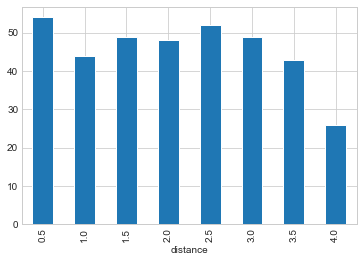

In [5]:
distances = dataset['distance']
reference_points = dataset.groupby(['distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

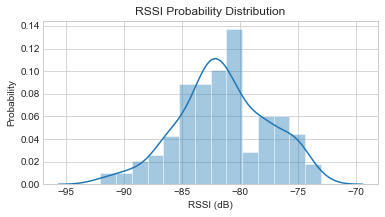

In [6]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

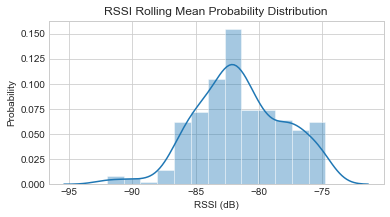

In [7]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

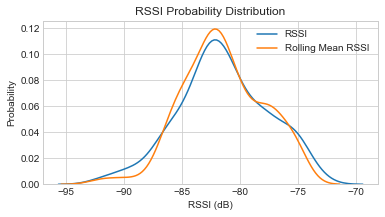

In [8]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Initialize Training Data
Training Data intialization for predictions purposes

In [9]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
train_Y = pd.DataFrame(dataset['distance']).values.reshape(-1,1)
default_groups = dataset['distance'].map(str)
data_plot_means = dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

# FREE PARAMETERS
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
distance_metris = ["euclidean", "manhattan", "canberra", "braycurtis"]
algorithms = ["brute","kd_tree","ball_tree","auto"]
weights = ["uniform","distance"]

,rssi_Value,rolling_mean_rssi
distance,,
0.5,-76.111111,-76.341498
1.0,-82.454545,-82.086742
1.5,-80.489796,-80.442177
2.0,-82.937500,-82.730398
2.5,-82.692308,-82.727106
3.0,-82.734694,-83.166667
3.5,-81.139535,-81.082171
4.0,-85.307692,-85.621154


### Plot Training Data
Graphical Display of the observations in the dataset

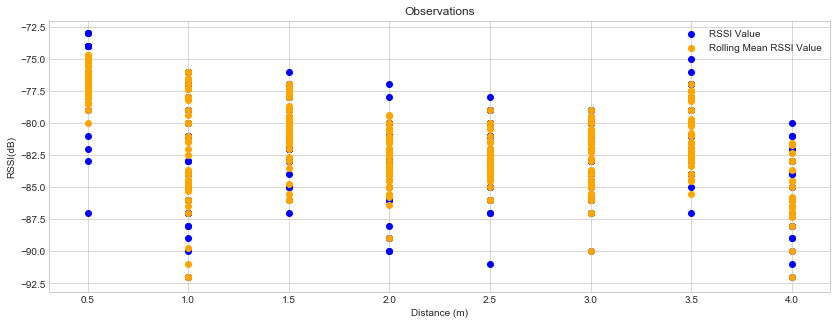

In [10]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Distance (m)')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [11]:
def structure_data(data,rsquared):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    std = data['error'].std()
    q25 = data['error'].quantile(q=0.25)
    q50= data['error'].quantile(q=0.5)
    q75 =data['error'].quantile(q=0.7)
    q95= data['error'].quantile(q=0.95)
    r_squared = rsquared
    minValue= data['error'].min()
    maxValue = data['error'].max()
    statistical_results = [mae,mse,rsme,std,q25,q50,q75,q95,minValue,maxValue,r_squared]
    return statistical_results

### KNN Experiments
Experiments with KNN algorithm

In [12]:
def compute_KNN(flag=0,colors=None,trainX_data = None, trainY_data = None,testX_data = None,testY_data = None, scaler = None,
                cross_validation = None,n_neighbors=5,weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski',
                metric_params=None, n_jobs=-1):
    knn_regression_estimator = KNeighborsRegressor(n_neighbors,weights,algorithm,leaf_size,p,metric,metric_params,n_jobs)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,knn_regression_estimator)
    else:
        main_estimator = knn_regression_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    else:
        main_estimator.fit(testX_data,testY_data)
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_groups)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    statistical_array = list()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        display(error_dataframe)
        df1 = error_dataframe.head(25)
        df1.plot(kind='bar',figsize=(12,6))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.show()
        plt.figure(figsize=(18,10))
        plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
        plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
        plt.xlim(testY_data.min()-1, testY_data.max()+1)
        plt.ylim(testX_data.min()-1, testX_data.max()+1)
        plt.xticks(np.arange(testY_data.min(), testY_data.max()+1, 1.0))
        plt.yticks(np.arange(testX_data.min(), testX_data.max()+1, 2.0))
        if colors is not None:
            plt.plot(predict_test, testX_data, color=colors,label='KNN')
        else:
            plt.plot(predict_test, testX_data, color='red', label='KNN')
        # Show and place the legent
        plt.legend(loc='upper right')
        plt.show()
    observed_errors = error_dataframe['Predicted'] - error_dataframe['Actual']
    error = pd.DataFrame(observed_errors, columns=["error"])
    result = pd.DataFrame(train_Y,columns=["distance"]).join(error)
    return structure_data(result,coefficient_determination)


#### 1st Experiment - Check Overfitting scenario (Without Testing Data) Using RSSI
Use KNNR to check the results on the training data alone

,Actual,Predicted
0,0.5,0.5
1,0.5,0.8
2,0.5,0.5
3,0.5,0.5
4,0.5,0.8
...,...,...
360,4.0,2.7
361,4.0,2.7
362,4.0,0.9
363,4.0,2.8


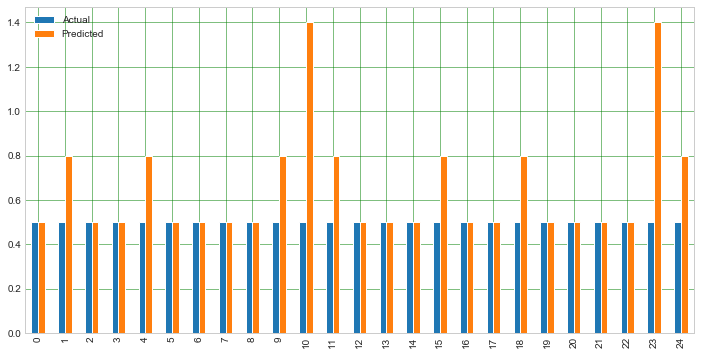

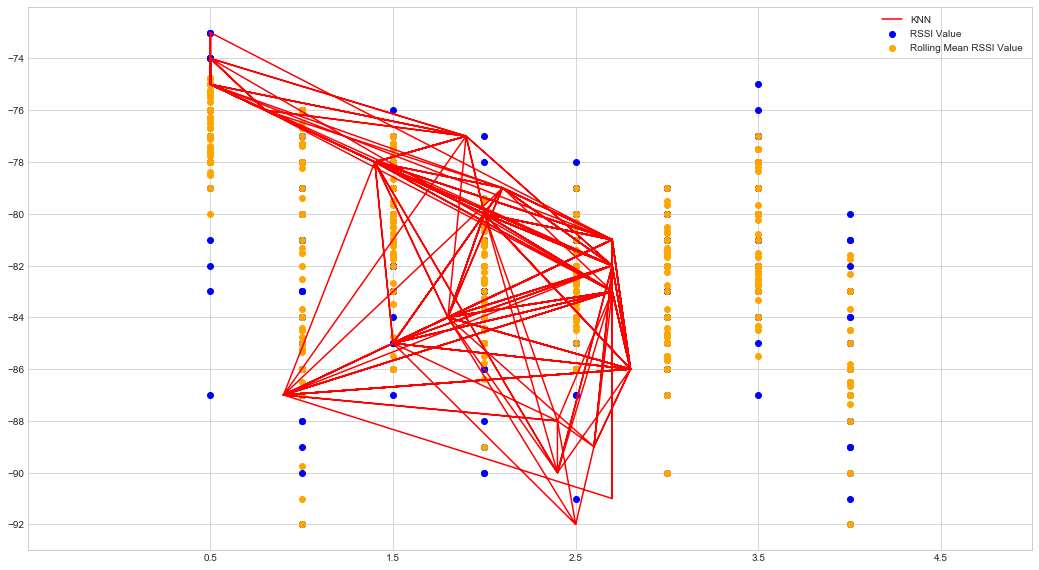

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.756712,0.961425,0.980523,0.97655,-0.8,0.0,0.4,1.4,-3.1,2.2,0.194523


In [13]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_KNN(flag=1,trainX_data=train_X_rssi,trainY_data=train_Y.ravel(),
                                   testX_data=train_X_rssi,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 2nd Experiment - Check Overfitting scenario (Without Testing Data) Using Rolling Mean
Use KNN to check the results on the training data alone

,Actual,Predicted
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
...,...,...
360,4.0,2.6
361,4.0,3.4
362,4.0,3.0
363,4.0,3.4


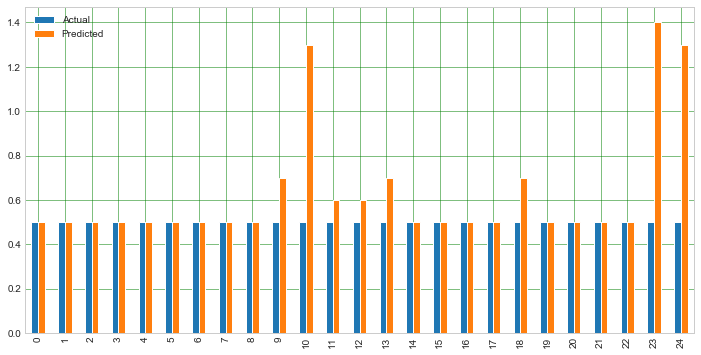

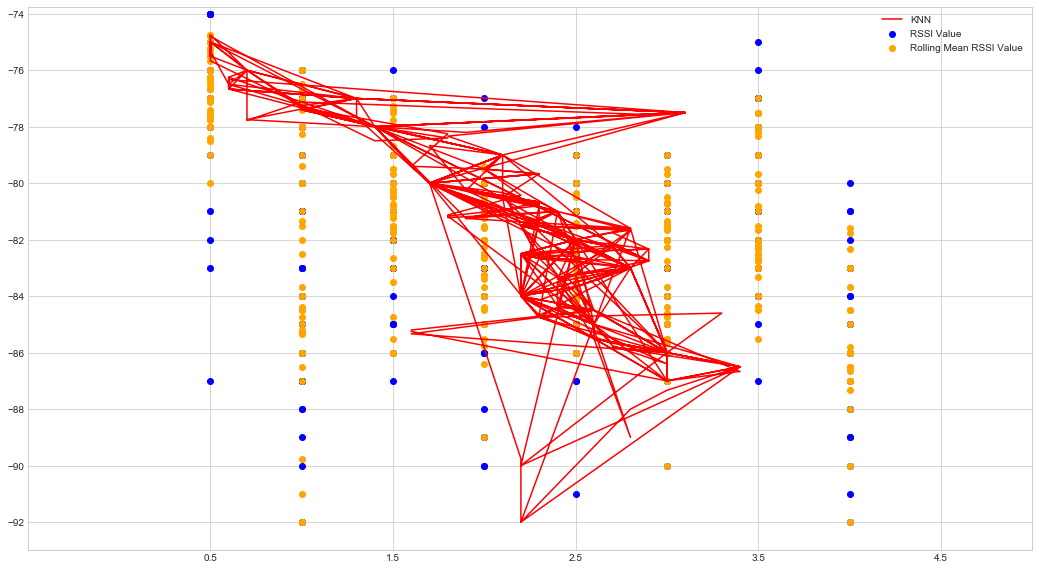

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.640822,0.687479,0.829144,0.830276,-0.5,0.0,0.4,1.3,-2.2,2.6,0.424033


In [14]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_KNN(flag=1,trainX_data=train_X_rolling_mean,trainY_data=train_Y.ravel(),
                                   testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 3rd Experiment - KNN with StratifiedKFold (RSSI pure)
Experiment using cross validation approach of StratifiedKFold

,Actual,Predicted
0,0.5,1.1
1,0.5,2.6
2,0.5,1.1
3,0.5,0.5
4,0.5,2.6
...,...,...
360,4.0,3.0
361,4.0,2.2
362,4.0,2.8
363,4.0,2.6


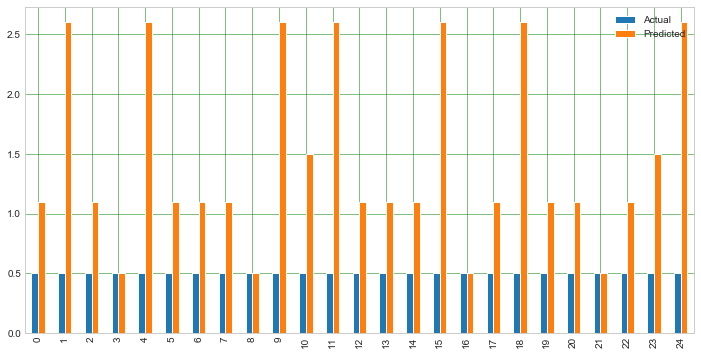

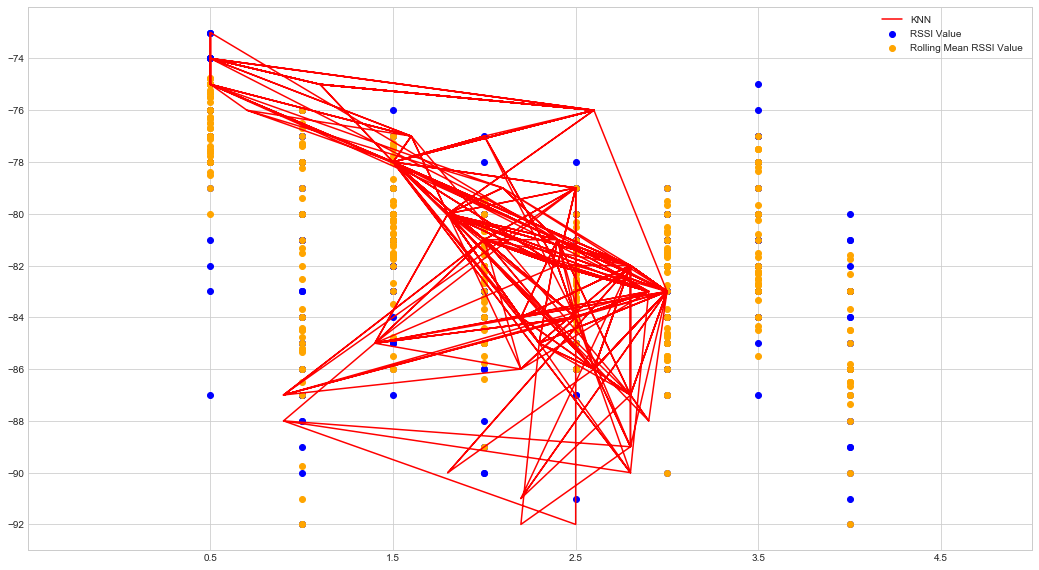

,Actual,Predicted
0,0.5,1.1
1,0.5,1.1
2,0.5,1.1
3,0.5,0.5
4,0.5,1.1
...,...,...
360,4.0,2.5
361,4.0,1.4
362,4.0,2.1
363,4.0,3.1


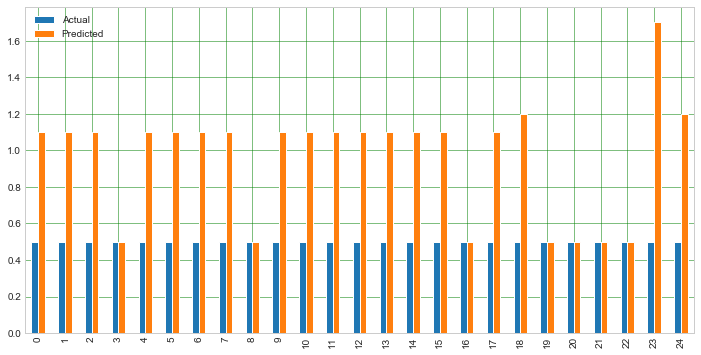

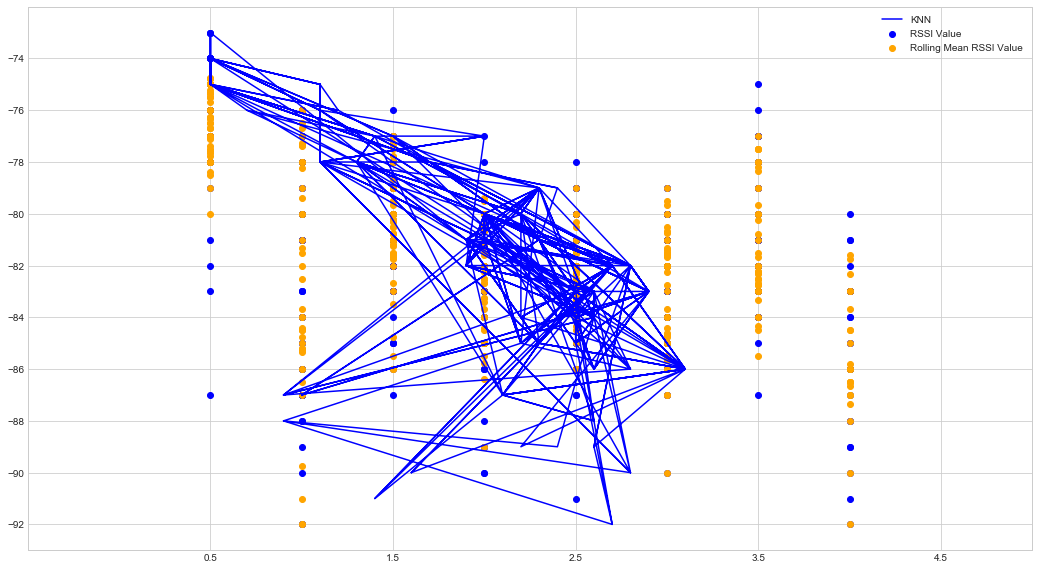

,Actual,Predicted
0,0.5,0.5
1,0.5,1.1
2,0.5,0.5
3,0.5,0.5
4,0.5,1.1
...,...,...
360,4.0,2.7
361,4.0,1.8
362,4.0,2.1
363,4.0,3.0


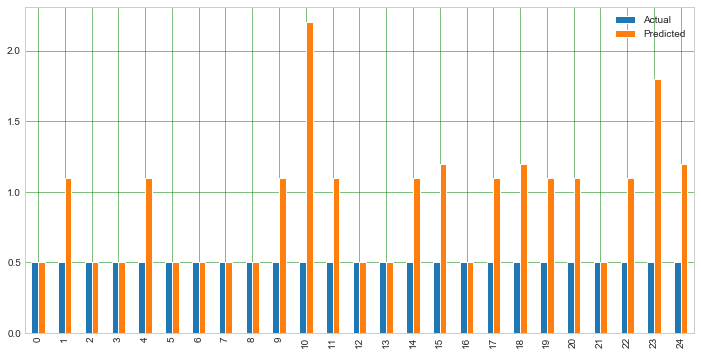

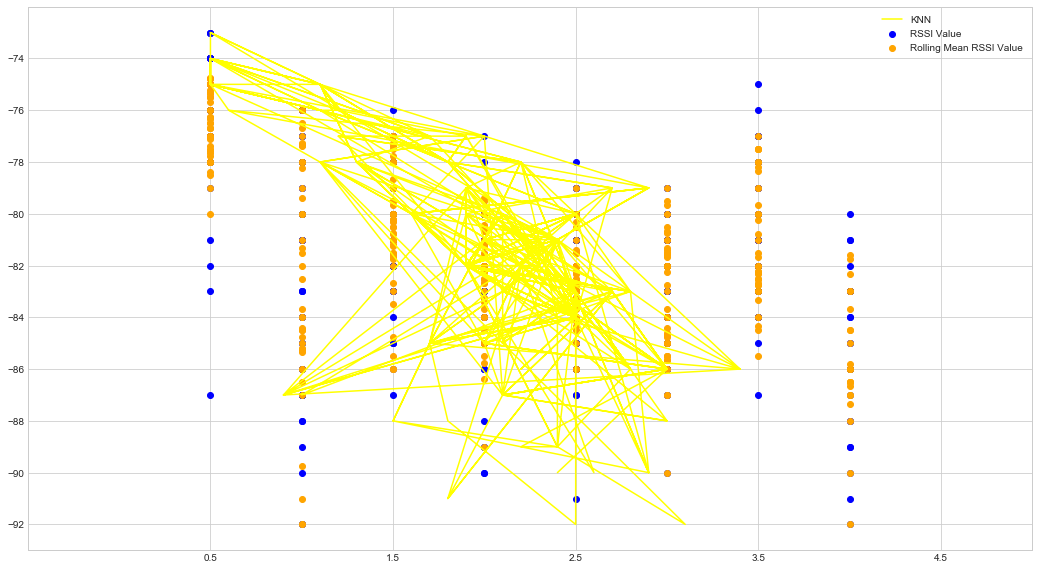

,Actual,Predicted
0,0.5,0.5
1,0.5,1.2
2,0.5,0.5
3,0.5,0.5
4,0.5,1.2
...,...,...
360,4.0,2.7
361,4.0,1.8
362,4.0,1.7
363,4.0,2.7


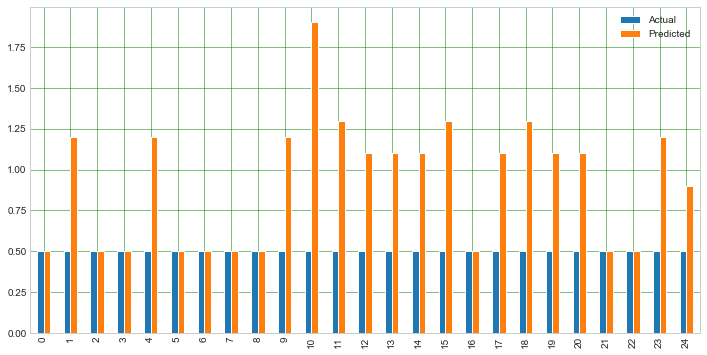

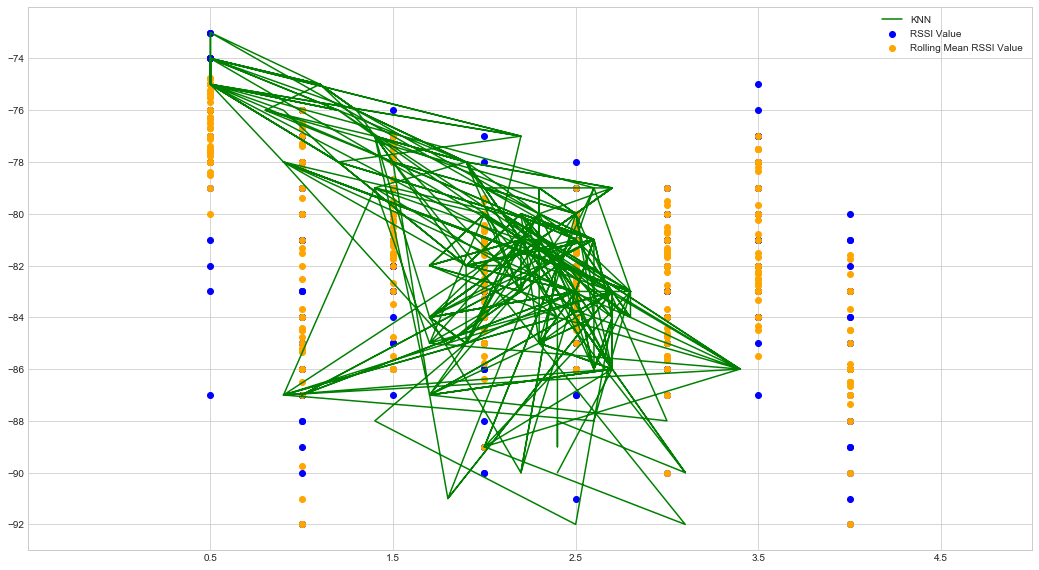

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,folds
1,0.794795,1.027425,1.013620,1.013264,-0.7,0.0,0.6,1.50,-3.1,2.2,0.139228,3
3,0.816986,1.077589,1.038070,1.034687,-0.8,0.0,0.4,1.68,-3.0,2.4,0.097201,5
2,0.829041,1.077699,1.038123,1.035550,-0.9,0.0,0.5,1.50,-3.0,2.4,0.097109,4
0,0.875890,1.199973,1.095433,1.096529,-0.7,0.0,0.6,1.80,-3.1,2.5,-0.005332,2


Number of Folds:  3


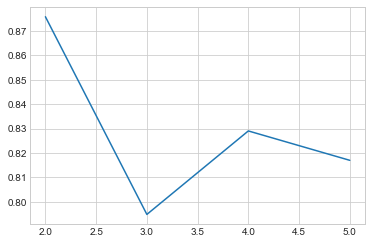

In [15]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
cross_validation_list = np.arange(2,6)
colors = ['red','blue','yellow','green']
counter = 0
results = list()
for cv in cross_validation_list:
    skf = StratifiedKFold(n_splits=cv)
    splited = skf.split(train_X_rssi,default_groups,default_groups)
    result = compute_KNN(flag = 1,colors=colors[counter],testX_data=train_X_rssi,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 4th Experiment - KNN with StratifiedKFold (Rolling Mean)
Experiment using cross validation approach of StratifiedKFold

,Actual,Predicted
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
...,...,...
360,4.0,2.6
361,4.0,3.4
362,4.0,3.6
363,4.0,3.4


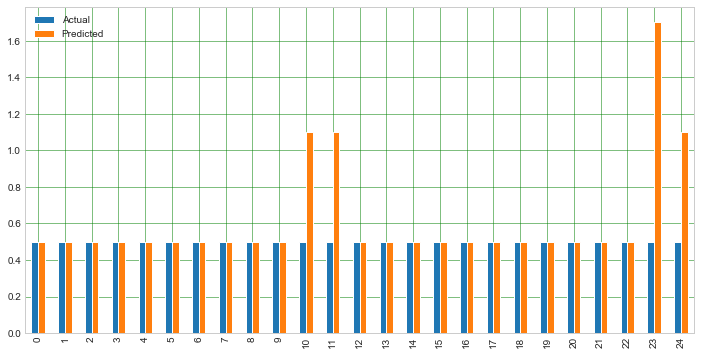

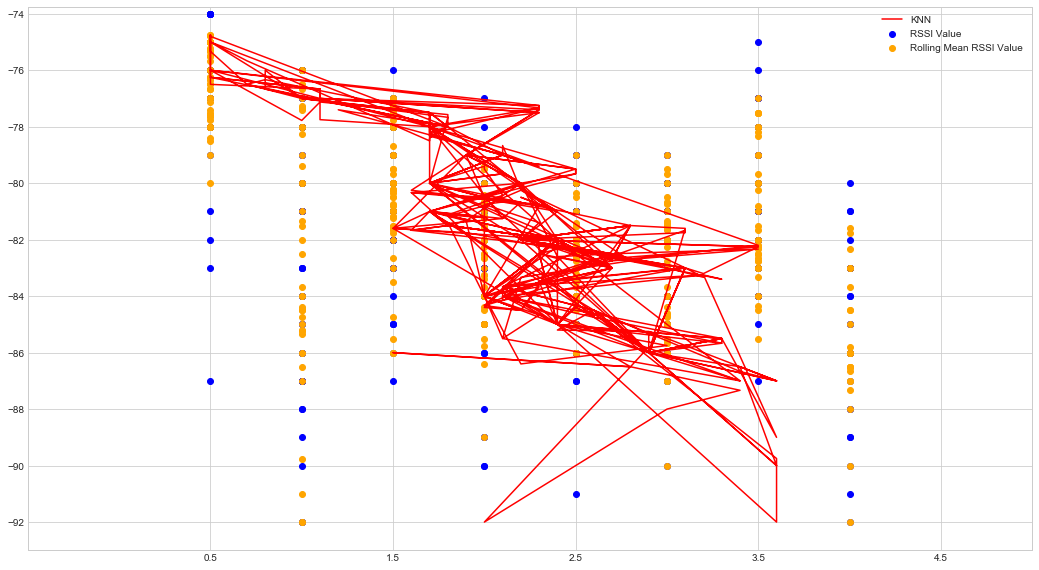

,Actual,Predicted
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
...,...,...
360,4.0,2.6
361,4.0,3.4
362,4.0,3.6
363,4.0,3.4


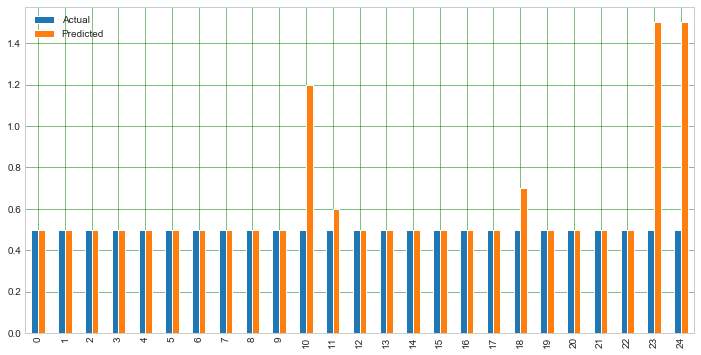

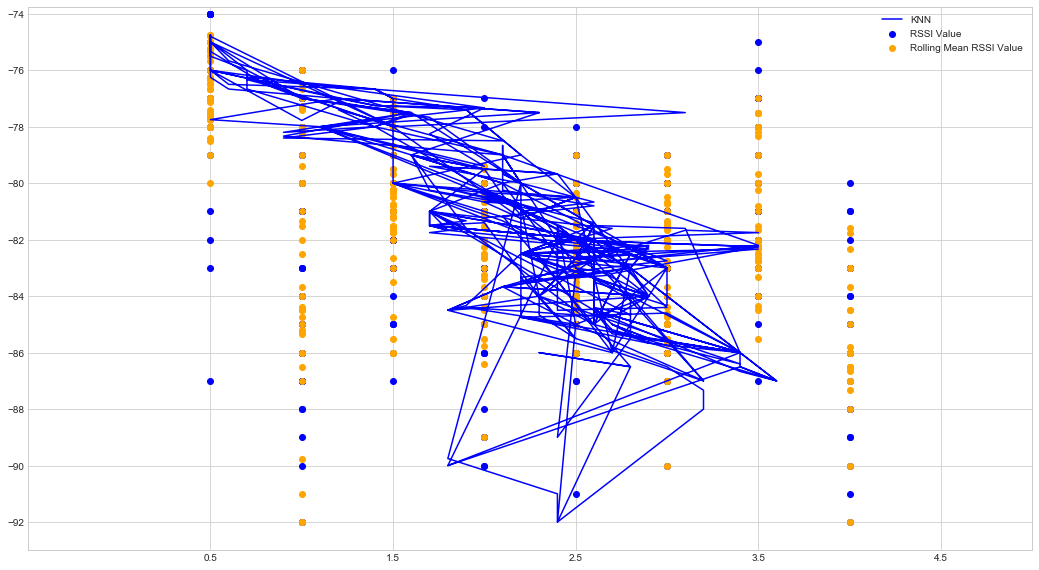

,Actual,Predicted
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
...,...,...
360,4.0,2.6
361,4.0,3.4
362,4.0,3.6
363,4.0,3.4


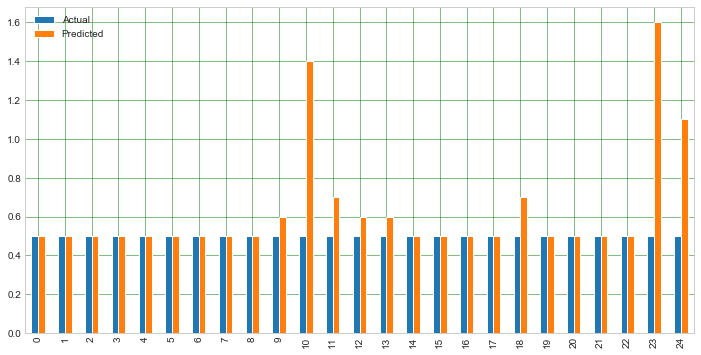

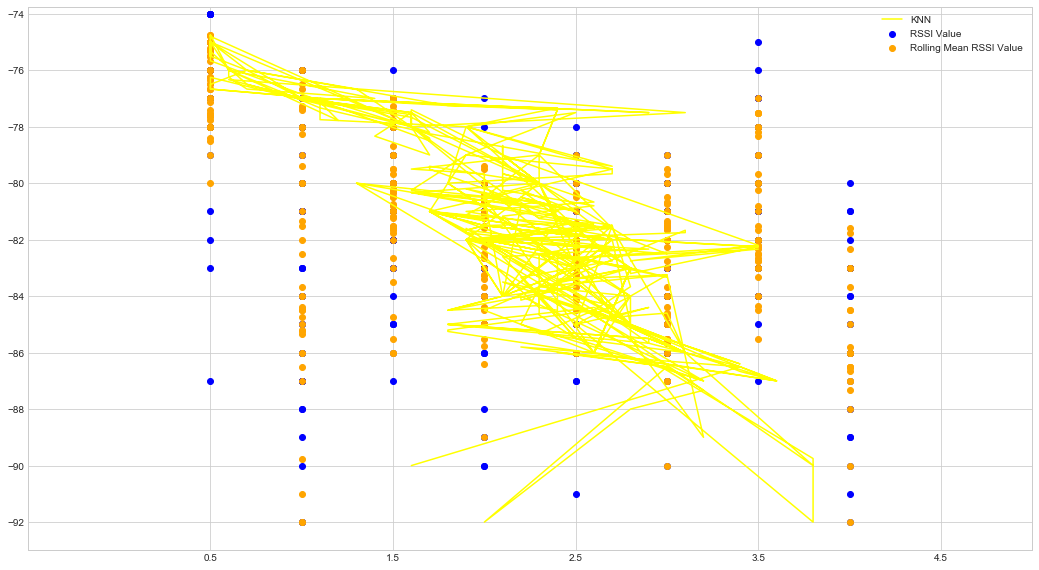

,Actual,Predicted
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
...,...,...
360,4.0,2.6
361,4.0,3.6
362,4.0,3.6
363,4.0,3.6


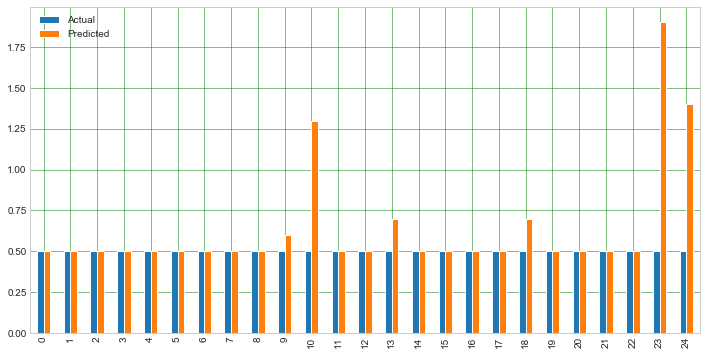

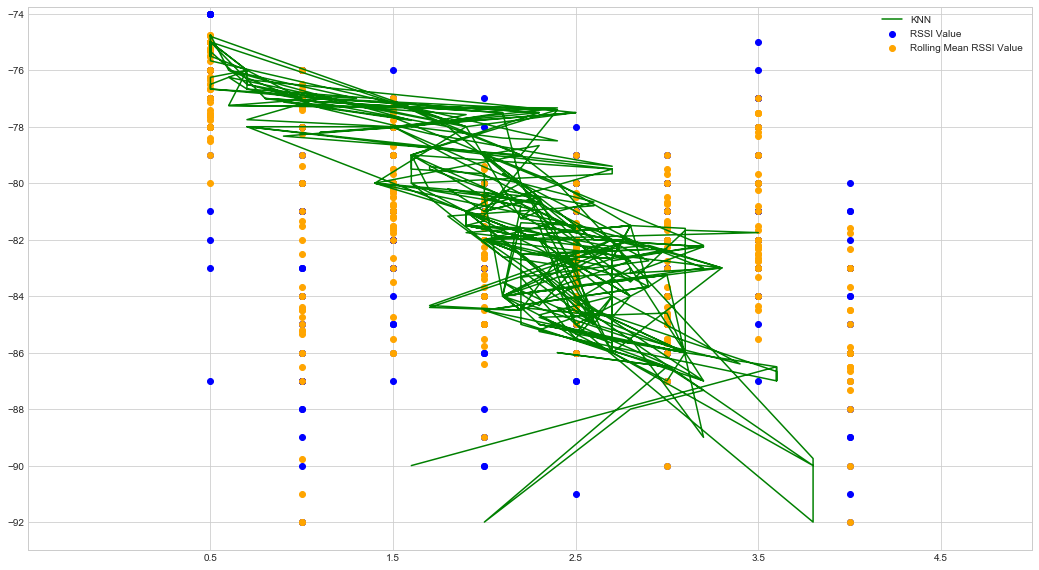

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,folds
1,0.760000,0.955014,0.977248,0.978278,-0.6,0.0,0.5,1.60,-2.6,2.6,0.199894,3
3,0.780822,1.012384,1.006173,1.006822,-0.6,0.0,0.5,1.68,-2.7,2.8,0.151830,5
0,0.789589,0.992384,0.996185,0.997322,-0.6,0.0,0.6,1.60,-2.5,2.6,0.168585,2
2,0.796712,1.035178,1.017437,1.018479,-0.7,0.0,0.5,1.60,-2.5,2.8,0.132732,4


Number of Folds:  3


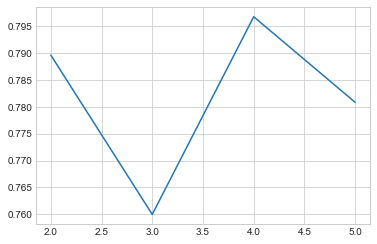

In [16]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
cross_validation_list = np.arange(2,6)
results = list()
colors = ['red','blue','yellow','green']
counter = 0
for cv in cross_validation_list:
    skf = StratifiedKFold(n_splits=cv)
    splited = skf.split(train_X_rolling_mean,default_groups)
    result = compute_KNN(flag = 1,colors=colors[counter],testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 5th Experiment - KNN with HoldOut (RSSI pure)
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,test_size
8,0.777508,0.894286,0.945667,0.941765,-0.5,0.20,0.70,1.700,-2.3,2.3,0.250778,0.9
6,0.753125,0.906406,0.952054,0.952602,-0.6,0.00,0.45,1.600,-3.0,2.1,0.238157,0.7
7,0.721918,0.908767,0.953293,0.952841,-0.5,0.00,0.50,1.600,-3.0,2.5,0.236464,0.8
5,0.776712,0.958493,0.979027,0.981222,-0.6,0.00,0.60,1.500,-2.3,2.0,0.197418,0.6
1,0.754795,0.962055,0.980844,0.986929,-0.6,0.00,0.40,1.660,-2.2,2.4,0.184995,0.2
3,0.788356,0.989521,0.994746,0.994814,-0.5,0.10,0.60,1.825,-2.0,2.6,0.168075,0.4
4,0.792350,1.017158,1.008543,0.997497,-0.6,0.20,0.70,1.700,-2.7,2.4,0.144001,0.5
2,0.840000,1.075636,1.037129,1.041869,-0.8,0.05,0.60,1.700,-2.2,2.6,0.098296,0.3
0,0.818919,1.114865,1.055872,1.063932,-0.6,0.00,0.52,2.000,-2.1,2.5,0.094751,0.1


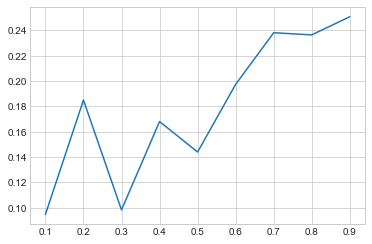

In [17]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rssi,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_KNN(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['r-squared'],ascending=False))
plt.plot(statistics['test_size'],statistics['r-squared'])

#### 6th Experiment - KNN with HoldOut (Rolling Mean)
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,test_size
7,0.707534,0.802260,0.895690,0.896434,-0.500,0.10,0.60,1.60,-2.8,2.1,0.325950,0.8
4,0.707104,0.827650,0.909753,0.910535,-0.700,0.00,0.34,1.39,-2.9,2.2,0.303483,0.5
2,0.713636,0.848091,0.920919,0.925032,-0.700,0.10,0.50,1.50,-2.4,2.5,0.289047,0.3
3,0.732877,0.852466,0.923291,0.926297,-0.675,0.05,0.40,1.55,-2.2,2.0,0.283302,0.4
6,0.730859,0.869805,0.932633,0.934417,-0.600,0.00,0.50,1.50,-3.0,2.4,0.268921,0.7
0,0.691892,0.945946,0.972598,0.980501,-0.500,0.00,0.20,1.66,-2.4,2.0,0.231910,0.1
5,0.748858,0.926393,0.962493,0.963236,-0.700,0.00,0.50,1.50,-2.7,2.4,0.224297,0.6
1,0.746575,0.926986,0.962801,0.969244,-0.600,0.00,0.50,1.50,-2.5,2.2,0.214703,0.2
8,0.776900,0.944498,0.971853,0.973285,-0.800,0.10,0.50,1.60,-2.3,2.5,0.208710,0.9


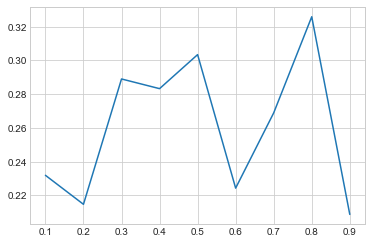

In [18]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rolling_mean,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_KNN(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['r-squared'],ascending=False))
plt.plot(statistics['test_size'],statistics['r-squared'])

#### 7th Experiment - KNN with LOGO (RSSI)
Experiment using cross validation approach of Leave One Group Out

In [19]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rssi,train_Y,groups=default_groups)
loo = compute_KNN(testX_data=train_X_rssi,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,1.106027,1.653562,1.285909,1.287646,-1.0,0.1,0.9,1.6,-3.1,2.3,-0.385347


#### 8th Experiment - KNN with LOGO (Rolling Mean)
Experiment using cross validation approach of Leave One Group Out

In [20]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rolling_mean,train_Y,groups=default_groups)
loo = compute_KNN(testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.967671,1.431726,1.196548,1.19818,-0.9,0.1,0.5,1.7,-2.8,2.6,-0.199494


#### 9th Experiment - Best cross-validation technique
Best parameters found using KNN

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,method,type
4,0.713636,0.848091,0.920919,0.925032,-0.7,0.10,0.5,1.5,-2.4,2.5,0.289047,HoldOut,Rolling Mean RSSI
5,0.760000,0.955014,0.977248,0.978278,-0.6,0.00,0.5,1.6,-2.6,2.6,0.199894,Stratified K-Fold,Rolling Mean RSSI
2,0.794795,1.027425,1.013620,1.013264,-0.7,0.00,0.6,1.5,-3.1,2.2,0.139228,Stratified K-Fold,RSSI Only
1,0.840000,1.075636,1.037129,1.041869,-0.8,0.05,0.6,1.7,-2.2,2.6,0.098296,HoldOut,RSSI Only
3,0.967671,1.431726,1.196548,1.198180,-0.9,0.10,0.5,1.7,-2.8,2.6,-0.199494,LOO,Rolling Mean RSSI
0,1.106027,1.653562,1.285909,1.287646,-1.0,0.10,0.9,1.6,-3.1,2.3,-0.385347,LOO,RSSI Only


Selected cross validation method:  HoldOut


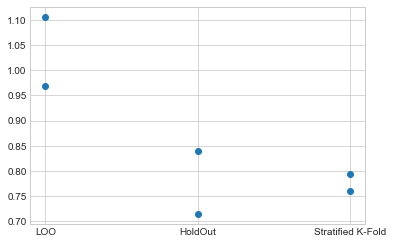

In [21]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','method','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
    holdout = compute_KNN(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
    loo = compute_KNN(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(scannedType)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(scannedType)
    results.append(holdout)
    skf = StratifiedKFold(n_splits=selected_fold)
    splited = skf.split(trainX_data,default_groups,groups=default_groups)
    skfold = compute_KNN(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)
    skfold.append('Stratified K-Fold')
    skfold.append(scannedType)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'],'o')
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### 10th Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,preprocessing,preprocessingFunc,type
6,0.702727,0.813727,0.902068,0.906064,-0.700,0.10,0.5,1.5,-2.2,2.5,0.317854,MaxAbsScaler,MaxAbsScaler(copy=True),Rolling Mean RSSI
5,0.707273,0.824545,0.908045,0.912018,-0.700,0.10,0.5,1.5,-2.2,2.5,0.308785,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Rolling Mean RSSI
7,0.711818,0.835909,0.914281,0.917970,-0.675,0.10,0.5,1.5,-2.2,2.5,0.299259,None,None,Rolling Mean RSSI
4,0.713636,0.848091,0.920919,0.925032,-0.700,0.10,0.5,1.5,-2.4,2.5,0.289047,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Rolling Mean RSSI
3,0.798182,0.946182,0.972719,0.976418,-0.800,0.05,0.6,1.5,-2.1,2.2,0.206817,None,None,RSSI Only
0,0.840000,1.075636,1.037129,1.041869,-0.800,0.05,0.6,1.7,-2.2,2.6,0.098296,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",RSSI Only
1,0.840000,1.075636,1.037129,1.041869,-0.800,0.05,0.6,1.7,-2.2,2.6,0.098296,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",RSSI Only
2,0.840000,1.075636,1.037129,1.041869,-0.800,0.05,0.6,1.7,-2.2,2.6,0.098296,MaxAbsScaler,MaxAbsScaler(copy=True),RSSI Only


Selected Preprocessing:  MaxAbsScaler


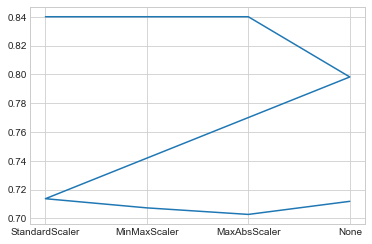

In [22]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_KNN(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_KNN(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_KNN(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

#### 11th Experiment -  Running the KNN function with the different weights

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,weights,type
2,0.713636,0.848091,0.920919,0.925032,-0.7,0.10,0.5,1.500000,-2.4,2.500000,0.289047,uniform,Rolling Mean RSSI
3,0.737325,0.937935,0.968471,0.969377,-0.5,0.05,0.5,1.595909,-2.5,2.666667,0.213730,distance,Rolling Mean RSSI
0,0.840000,1.075636,1.037129,1.041869,-0.8,0.05,0.6,1.700000,-2.2,2.600000,0.098296,uniform,RSSI Only
1,0.850909,1.125414,1.060855,1.065699,-0.8,0.05,0.6,1.700000,-2.2,3.000000,0.056567,distance,RSSI Only


Selected weight:  uniform


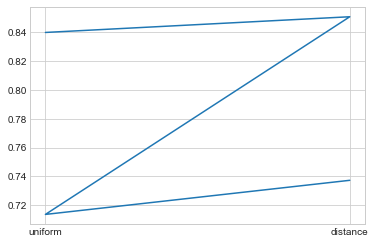

In [23]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','weights','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for weight in weights:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,Y_train,groups=default_groups)
            result = compute_KNN(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                               weights = weight)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_KNN(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                weights = weight)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_KNN(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                               weights = weight)
        result.append(weight)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['weights'],statistics['mae'])
selected_weight = statistics.sort_values(by=['mae'])['weights'].head(1).values[0]
print("Selected weight: ",selected_weight)

#### 12th Experiment - Running the KNN function with the different algorithms

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,algorithm,type
6,0.712727,0.847818,0.920770,0.924869,-0.700,0.10,0.5,1.50,-2.4,2.5,0.289275,ball_tree,Rolling Mean RSSI
5,0.713636,0.848091,0.920919,0.925032,-0.700,0.10,0.5,1.50,-2.4,2.5,0.289047,kd_tree,Rolling Mean RSSI
7,0.713636,0.848091,0.920919,0.925032,-0.700,0.10,0.5,1.50,-2.4,2.5,0.289047,auto,Rolling Mean RSSI
4,0.737273,0.904273,0.950933,0.953963,-0.675,0.00,0.4,1.51,-2.4,2.8,0.241950,brute,Rolling Mean RSSI
0,0.814545,1.003273,1.001635,1.003823,-0.775,0.15,0.6,1.40,-2.6,2.2,0.158958,brute,RSSI Only
1,0.840000,1.075636,1.037129,1.041869,-0.800,0.05,0.6,1.70,-2.2,2.6,0.098296,kd_tree,RSSI Only
2,0.840000,1.075636,1.037129,1.041869,-0.800,0.05,0.6,1.70,-2.2,2.6,0.098296,ball_tree,RSSI Only
3,0.840000,1.075636,1.037129,1.041869,-0.800,0.05,0.6,1.70,-2.2,2.6,0.098296,auto,RSSI Only


Selected algorithm:  ball_tree


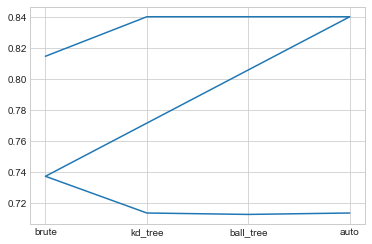

In [24]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','algorithm','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for algorithm in algorithms:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,Y_train,groups=default_groups)
            result = compute_KNN(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                               algorithm= algorithm)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_KNN(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                algorithm= algorithm)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_KNN(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                               algorithm= algorithm)
        result.append(algorithm)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['algorithm'],statistics['mae'])
selected_algorithm = statistics.sort_values(by=['mae'])['algorithm'].head(1).values[0]
print("Selected algorithm: ",selected_algorithm)

#### 13th Experiment - Running the KNN function with the different distance metrics

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,distance,type
4,0.713636,0.848091,0.920919,0.925032,-0.7,0.10,0.5,1.5,-2.4,2.5,0.289047,euclidean,Rolling Mean RSSI
5,0.713636,0.848091,0.920919,0.925032,-0.7,0.10,0.5,1.5,-2.4,2.5,0.289047,manhattan,Rolling Mean RSSI
6,0.715455,0.859909,0.927313,0.931427,-0.7,0.10,0.5,1.5,-2.4,2.5,0.279140,canberra,Rolling Mean RSSI
7,0.715455,0.859909,0.927313,0.931427,-0.7,0.10,0.5,1.5,-2.4,2.5,0.279140,braycurtis,Rolling Mean RSSI
2,0.836364,1.065818,1.032385,1.037110,-0.8,0.05,0.6,1.7,-2.1,2.6,0.106526,canberra,RSSI Only
3,0.836364,1.065818,1.032385,1.037110,-0.8,0.05,0.6,1.7,-2.1,2.6,0.106526,braycurtis,RSSI Only
0,0.840000,1.075636,1.037129,1.041869,-0.8,0.05,0.6,1.7,-2.2,2.6,0.098296,euclidean,RSSI Only
1,0.840000,1.075636,1.037129,1.041869,-0.8,0.05,0.6,1.7,-2.2,2.6,0.098296,manhattan,RSSI Only


Selected distance:  euclidean


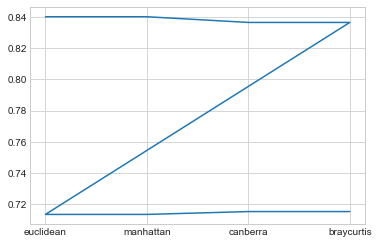

In [25]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','distance','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for distance in distance_metris:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,Y_train,groups=default_groups)
            result = compute_KNN(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                               metric = distance)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_KNN(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                metric = distance)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_KNN(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                               metric = distance)
        result.append(distance)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['distance'],statistics['mae'])
selected_distance = statistics.sort_values(by=['mae'])['distance'].head(1).values[0]
print("Selected distance: ",selected_distance)

#### 14th Experiment - Checking the k parameter

{'knn__n_neighbors': 30}
Max accuracy:  -0.8357420091324201


Text(0, 0.5, 'Cross-validated accuracy')

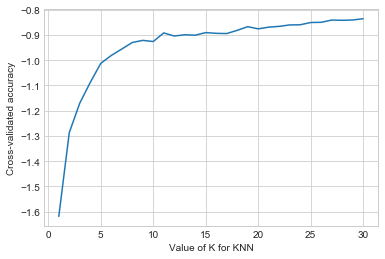

In [26]:
skf = StratifiedKFold()
splited = skf.split(train_X_rolling_mean,default_groups,groups=default_groups)
knn_regressor_estimator = KNeighborsRegressor() #init knn regressor estimator
k_range = list(range(1, 31))
param_grid = {'knn__n_neighbors': k_range}
# Create a pipeline
pipe = Pipeline([('standardizer', StandardScaler()), ('knn', knn_regressor_estimator)])
estimator = GridSearchCV(pipe, param_grid,cv=splited,scoring=sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error,
                                                    greater_is_better=False,
                                                    multioutput="uniform_average"))
#fit model to data
estimator.fit(train_X_rolling_mean, train_Y)
print(estimator.best_params_)
best_knn = estimator.best_params_['knn__n_neighbors']
grid_mean_scores = estimator.cv_results_['mean_test_score']
print('Max accuracy: ', max(grid_mean_scores))
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

### Run GridSearch for parameter tunning

In [27]:
results = []
k_range = list(range(1, 31))
tuned_parameters = {
    'knn__n_neighbors': k_range,
    'knn__metric':distance_metris,
    'knn__weights':weights,
    'knn__algorithm':algorithms
}
scores = ['neg_mean_absolute_error']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    pipe = Pipeline([('standardizer', StandardScaler()), ('knn', KNeighborsRegressor())])
    clf = GridSearchCV(
       pipe, tuned_parameters, cv=StratifiedKFold(n_splits=selected_fold, shuffle=True, random_state=6).split(train_X_rolling_mean, default_groups),scoring=score,n_jobs=-1,verbose=1
    )
    clf.fit(train_X_rolling_mean,train_Y.ravel())
    clf.best_params_['score'] = score
    results.append(clf.best_params_)
gridcv_results = pd.DataFrame(results)
display(gridcv_results)

# Tuning hyper-parameters for neg_mean_absolute_error

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2583 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:    3.0s finished


,knn__algorithm,knn__metric,knn__n_neighbors,knn__weights,score
0,brute,canberra,28,uniform,neg_mean_absolute_error


### Best Parameters
Display the best parameters tunned throughout the experiments

In [28]:
conclusion_cols=['K Parameter','Cross Validation','Weight','Preprocessing','Algorithm','Distance']
conclusion_list = [best_knn,selected_method,selected_weight,selected_preprocessing,selected_algorithm,selected_distance]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,K Parameter,Cross Validation,Weight,Preprocessing,Algorithm,Distance
0,30,HoldOut,uniform,MaxAbsScaler,ball_tree,euclidean


### Best Results
Compute KNN with the best parameters in both RSSI and Rolling Mean

In [31]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
        result = compute_KNN(n_neighbors=best_knn,testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                            algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(trainX_data,default_groups,groups=default_groups)
        result = compute_KNN(n_neighbors=best_knn,testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                            algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
        result = compute_KNN(n_neighbors=best_knn,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                             scaler=StandardScaler(),algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
    result.append(scannedType)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
statistical_cols_csv = ['mae','mse','rmse']
statistical_cols_csv.append('Experimentation')
result_csv = result[0:3]
result_csv.append('KNN Regressor')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../proximity_results.csv',mode='a',index=False)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type
1,0.713788,0.786427,0.886807,0.890600,-0.7125,0.158333,0.538333,1.541667,-2.200000,1.783333,0.340740,Rolling Mean RSSI
0,0.725909,0.795775,0.892062,0.896131,-0.6000,0.033333,0.505000,1.400000,-1.966667,1.900000,0.332903,RSSI Only


### Best Results - Testing data being 1000 plot points
Experiment with testing data of 1000 plot points

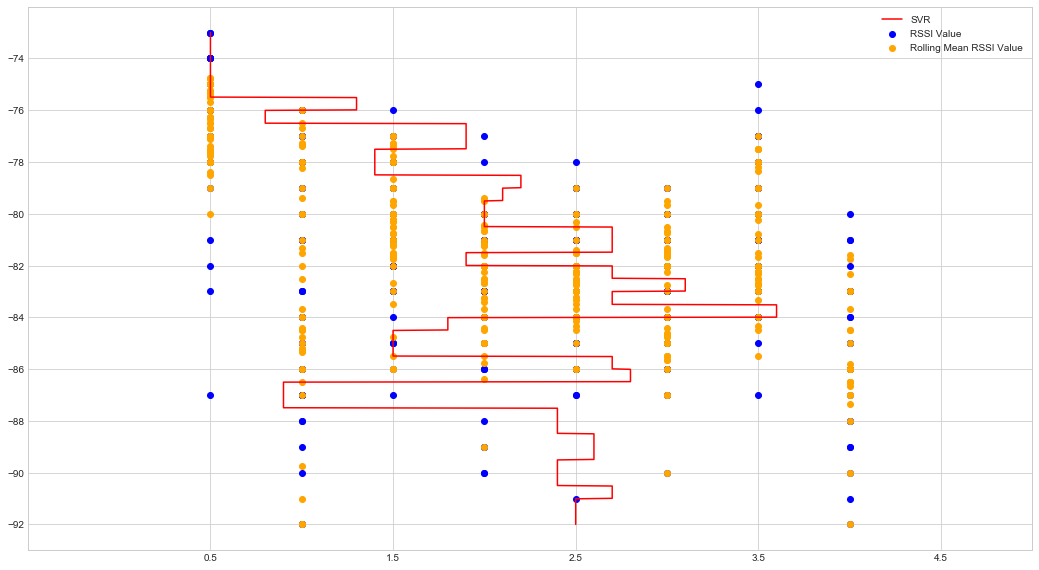

In [30]:
testX_data = np.linspace(dataset['rssi_Value'].min(), dataset['rssi_Value'].max(), 1000).reshape(-1,1)
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
svr_estimator = KNeighborsRegressor()
main_estimator = make_pipeline(StandardScaler(),svr_estimator)
main_estimator.fit(train_X_rssi,train_Y.ravel())
predict_test = main_estimator.predict(testX_data)
plt.show()
plt.figure(figsize=(18,10))
plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.xlim(train_Y.min()-1, train_Y.max()+1)
plt.ylim(train_X_rssi.min()-1, train_X_rssi.max()+1)
plt.xticks(np.arange(train_Y.min(), train_Y.max()+1, 1.0))
plt.yticks(np.arange(train_X_rssi.min(), train_X_rssi.max()+1, 2.0))
plt.plot(predict_test, testX_data, color='red', label='SVR')
# Show and place the legent
plt.legend(loc='upper right')
plt.show()